This project is related to image segmentation. Image Segmentation is a problem of dividing an image into different segments, where each segment contations pixels which shares some common features. Image segmentation is very usefull in thesedays whether it is in medical field to separate tumors in an image, or to remove an object from an image or apply different transformation to an image.

There are three types of image segmentation:-
1. Semantic segmentation:- In this segmentation each pixel of the image is assigned a class. All the instances of the pixel wont be classified differently.
2. Instance Segmentation:- In Instance segmentation all the instances of the classes are annotated differently.
3. Panoptic Segmentation:-  In this segmentation the image is segmented into both semantic and Instance based.

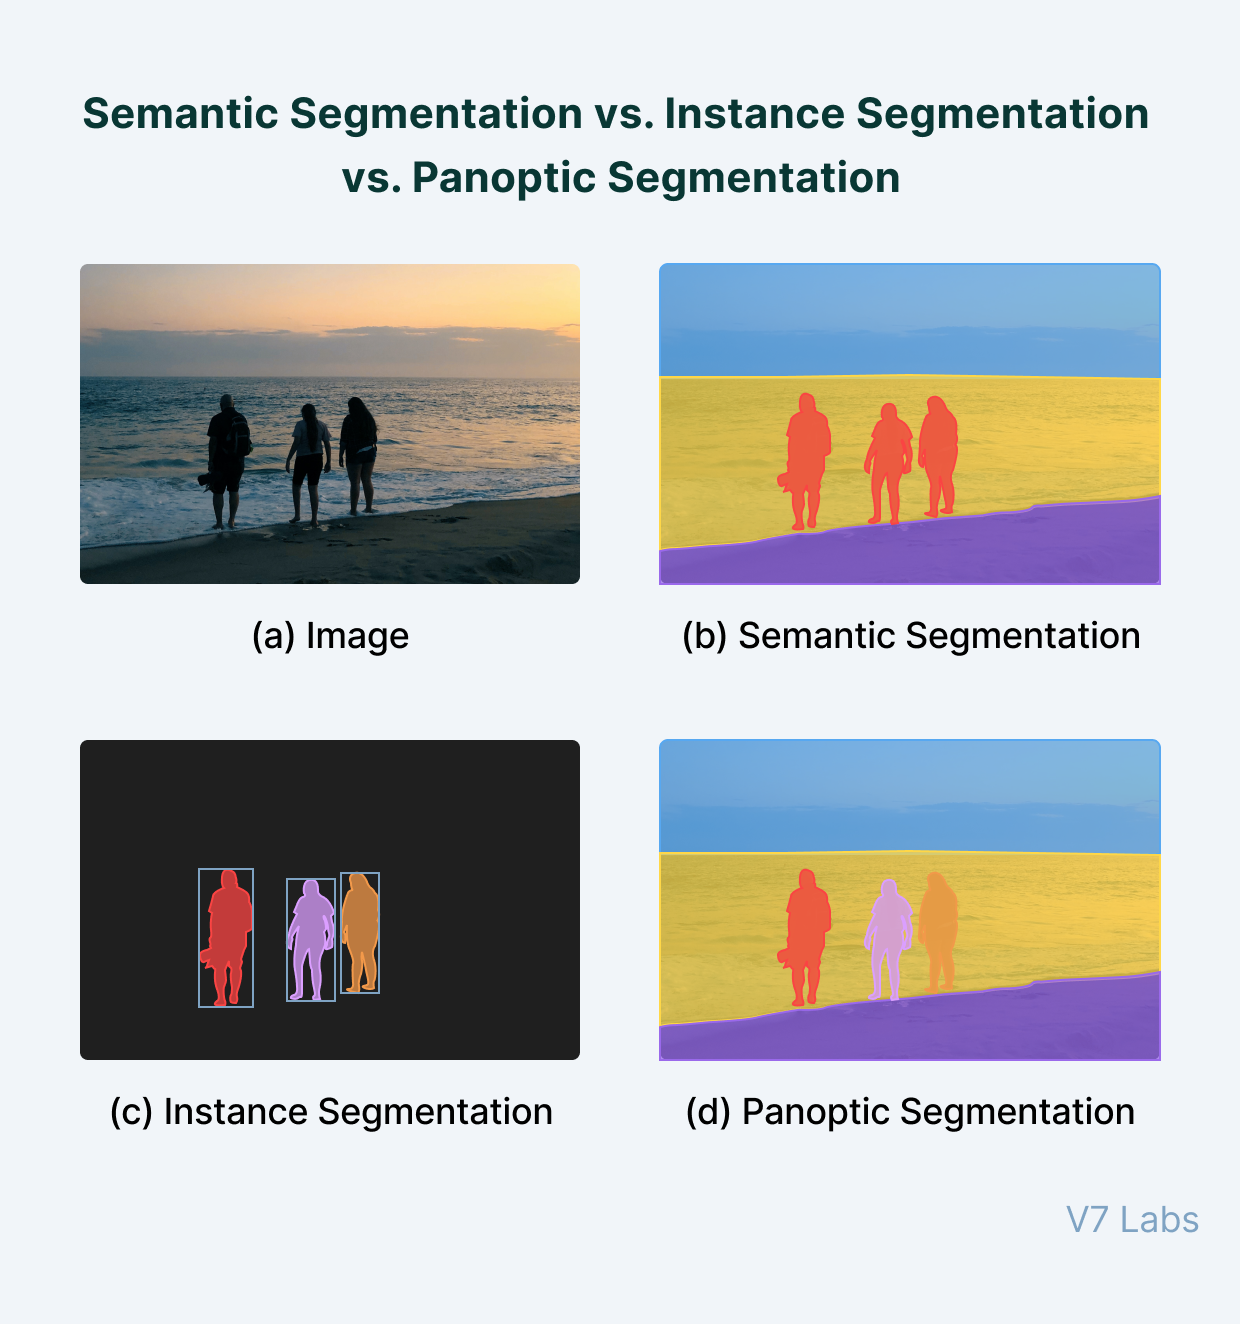

This project is based on semantic segmentation

The dataset we have used in this project is ADE20K dataset containing wide varity of categories and objects.There are 150 different types of objects and categories are present in this dataset.

#### Loading liberaries

In [9]:
!pip3 install torch torchvision torchaudio


  Using cached torchvision-0.18.1-cp39-cp39-win_amd64.whl (1.2 MB)


ERROR: Cannot uninstall 'TBB'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


  Using cached torch-2.3.1-cp39-cp39-win_amd64.whl (159.7 MB)
  Using cached mkl-2021.4.0-py2.py3-none-win_amd64.whl (228.5 MB)
  Using cached intel_openmp-2021.4.0-py2.py3-none-win_amd64.whl (3.5 MB)
  Using cached tbb-2021.12.0-py3-none-win_amd64.whl (286 kB)
  Attempting uninstall: tbb
    Found existing installation: TBB 0.2


In [1]:
import os
import numpy as np
import torch
# from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau
from PIL import Image
import albumentations as alb
import tqdm
from albumentations.pytorch import ToTensorV2
# from torchvision.transforms import ToPILImage
import tensorflow as tf
from tensorflow.keras import layers, models

# import segmentation_models as sm
from tensorflow.keras.applications import VGG16
from tensorflow.keras.metrics import MeanIoU


from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.11 (you have 1.4.8). Upgrade using: pip install --upgrade albumentations


Connecting Colab with Kaggle Environment

In [2]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

Downloading the dataset

In [3]:
!kaggle datasets download -d kallurivasanthsai/adechallengedata2016

Dataset URL: https://www.kaggle.com/datasets/kallurivasanthsai/adechallengedata2016
License(s): unknown
 99% 1.09G/1.10G [00:15<00:00, 89.2MB/s]
100% 1.10G/1.10G [00:15<00:00, 74.6MB/s]


In [4]:
!unzip /content/adechallengedata2016.zip

Streaming output truncated to the last 5000 lines.
  inflating: ade/ADEChallengeData2016/images/validation/ADE_val_00000357.jpg  
  inflating: ade/ADEChallengeData2016/images/validation/ADE_val_00000358.jpg  
  inflating: ade/ADEChallengeData2016/images/validation/ADE_val_00000359.jpg  
  inflating: ade/ADEChallengeData2016/images/validation/ADE_val_00000360.jpg  
  inflating: ade/ADEChallengeData2016/images/validation/ADE_val_00000361.jpg  
  inflating: ade/ADEChallengeData2016/images/validation/ADE_val_00000362.jpg  
  inflating: ade/ADEChallengeData2016/images/validation/ADE_val_00000363.jpg  
  inflating: ade/ADEChallengeData2016/images/validation/ADE_val_00000364.jpg  
  inflating: ade/ADEChallengeData2016/images/validation/ADE_val_00000365.jpg  
  inflating: ade/ADEChallengeData2016/images/validation/ADE_val_00000366.jpg  
  inflating: ade/ADEChallengeData2016/images/validation/ADE_val_00000367.jpg  
  inflating: ade/ADEChallengeData2016/images/validation/ADE_val_00000368.jpg  
 

In [2]:
os.chdir("C:\\Users\\shri\\Data_Science\\Guissipo Longo\\Mid_Term_Project_Image_segmentation_dataset\\ADE20K Dataset")

In [3]:
### paths to all images directories

training_image = os.path.join(os.getcwd(),".\\ADEChallengeData2016\\images\\training")
training_mask = os.path.join(os.getcwd(),".\\ADEChallengeData2016\\annotations\\training")
validation_image = os.path.join(os.getcwd(),".\\ADEChallengeData2016\\images\\validation")
validation_mask = os.path.join(os.getcwd(),".\\ADEChallengeData2016\\annotations\\validation")
test_image = os.path.join(os.getcwd(),".\\release_test\\testing")

In [4]:
print("Number of training images {}".format(len(os.listdir(training_image))))
print("Number of training mask {}".format(len(os.listdir(training_mask))))
print("Number of validation images {}".format(len(os.listdir(validation_image))))
print("Number of validation mask {}".format(len(os.listdir(validation_mask))))
print("Number of test images {}".format(len(os.listdir(test_image))))

Number of training images 20210
Number of training mask 20210
Number of validation images 2000
Number of validation mask 2000
Number of test images 3352


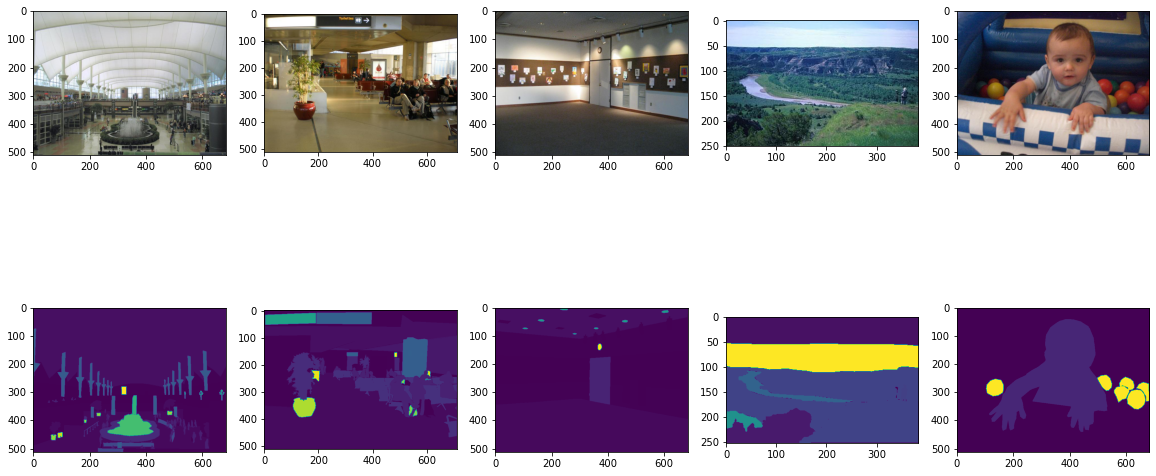

In [27]:
plt.figure(figsize = (20,10))
for i in range(1,6):
    plt.subplot(2,5,i)
    training_img = Image.open(os.path.join(training_image, os.listdir(training_image)[i-1]))
    plt.imshow(training_img)

    plt.subplot(2,5,i+5)
    val_img = Image.open(os.path.join(training_mask, os.listdir(training_mask)[i-1]))
    plt.imshow(val_img)


In [6]:
training_img_1 = Image.open(os.path.join(training_image, os.listdir(training_image)[1]))
training_img_5 = Image.open(os.path.join(training_image, os.listdir(training_image)[5]))
training_img_100 = Image.open(os.path.join(training_image, os.listdir(training_image)[100]))
val_img_2 = Image.open(os.path.join(training_mask, os.listdir(training_mask)[5]))
print(training_img_1.size)
print(training_img_5.size)
print(training_img_100.size)
print(val_img_2.size)

(711, 512)
(512, 973)
(677, 512)
(512, 973)


In [35]:
def load_mask(mask_path):
    # Load the mask image
    mask = load_img(mask_path, color_mode='grayscale')
    mask = img_to_array(mask)
    
    # Convert mask to integer type
    mask = mask.astype(np.int32)
    
    return mask

def count_classes(mask):
    # Find unique values in the mask
    unique_classes = np.unique(mask)
    
    # Count the number of unique values
    num_classes = len(unique_classes)
    
    return unique_classes, num_classes


In [37]:
def find_total_classes(mask_dir):
    all_unique_classes = set()
    
    for mask_file in os.listdir(mask_dir):
        mask_path = os.path.join(mask_dir, mask_file)
        mask = load_mask(mask_path)
        unique_classes = np.unique(mask)
        all_unique_classes.update(unique_classes)
        
    return all_unique_classes, len(all_unique_classes)

# Example usage for the entire dataset
mask_dir = training_annotation
all_unique_classes, total_classes = find_total_classes(training_mask)

print(f"All unique classes in the dataset: {all_unique_classes}")
print(f"Total number of unique classes: {total_classes}")

All unique classes in the dataset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150}
Total number of unique classes: 151


1. The training dataset consists of 20210 images, validation dataset consists of 2000 and test dataset consists of 3352images.
2. As from the above images and dataset description we came to know that there are 151 different objects and categories are present in this dataset like bed, door, sky, water, plant , animal etc.
3. The dimensions of the images are different. We need to resize all the images to a fixed dimentions. As the deep learning models require inputs to be of same dimentions and in batch processing the baches should also be of same size

In [ ]:
training_img_paths = [os.path.join(training_image,x) for x in os.listdir(training_image)]
training_mask_paths = [os.path.join(training_annotation,x) for x in os.listdir(training_annotation)]
validation_img_paths = [os.path.join(validation_image,x) for x in os.listdir(validation_image)]
validation_mask_paths = [os.path.join(validation_annotation,x) for x in os.listdir(validation_annotation)]

As we have limited hardware capabilities we will train our model on validation images. We will split our validation dataset into ratio of 1600:400 for training and validation respectively

In [29]:
def load_image(image_path):
    image = load_img(image_path, target_size=(256, 256))
    image = img_to_array(image) / 255.0  # Normalize to [0, 1]
    return image

def load_mask(mask_path):
    mask = load_img(mask_path, target_size=(256, 256), color_mode='grayscale')
    mask = img_to_array(mask)
    mask = np.squeeze(mask)  # Remove the channel dimension
    mask = mask.astype(np.int32)
    return mask

def process_path(image_path, mask_path):
    image = tf.numpy_function(load_image, [image_path], tf.float32)
    mask = tf.numpy_function(load_mask, [mask_path], tf.int32)
    mask = tf.expand_dims(mask, axis=-1)  # Add channel dimension to mask
    return image, mask

def set_shapes(image, mask):
    image.set_shape([256, 256, 3])
    mask.set_shape([256, 256, 1])
    return image, mask

def load_dataset(image_dir, mask_dir):
    image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])
    mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])
    return image_paths, mask_paths

# Define dataset directories
image_dir = validation_image
mask_dir = validation_mask

# Load dataset paths
image_paths, mask_paths = load_dataset(image_dir, mask_dir)

# Split dataset into training and validation sets
train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42)

print(f"Number of training images: {len(train_image_paths)}")
print(f"Number of validation images: {len(val_image_paths)}")

# Create tf.data.Dataset for training and validation
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_mask_paths))
val_dataset = tf.data.Dataset.from_tensor_slices((val_image_paths, val_mask_paths))

# Map the process_path function
train_dataset = train_dataset.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Ensure shapes are set correctly to avoid "unknown" TensorShape issue
train_dataset = train_dataset.map(set_shapes, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.map(set_shapes, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Prepare training dataset
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=100)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Prepare validation dataset
val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)



# Training the model


Number of training images: 1600
Number of validation images: 400


Creating a simple 3-layer encoder and decoder fully connected convolution model with batchnormalidation layer. Lets see how it performs on our dataset

In [8]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.UpSampling2D((2, 2)))
model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.UpSampling2D((2, 2)))
model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.UpSampling2D((2, 2)))
model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(151, (1, 1), activation='softmax', padding='same'))

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Compile the model
initial_learning_rate = 0.001
optimizer = Adam(learning_rate=initial_learning_rate)
model.compile(optimizer=optimizer, loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 256, 256, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 128, 128, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 128, 128, 64)      2

In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
lr_scheduler = LearningRateScheduler(scheduler)

# Training the model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=15, callbacks=[early_stopping, checkpoint, lr_scheduler])

Epoch 1/15
50/50 [==============================] - 46s 627ms/step - loss: 4.5299 - accuracy: 0.1688 - val_loss: 5.1458 - val_accuracy: 0.1431 - lr: 0.0010
Epoch 2/15


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


50/50 [==============================] - 29s 569ms/step - loss: 3.9460 - accuracy: 0.2657 - val_loss: 5.3458 - val_accuracy: 0.0550 - lr: 0.0010
Epoch 3/15
50/50 [==============================] - 29s 572ms/step - loss: 3.6248 - accuracy: 0.2920 - val_loss: 6.0994 - val_accuracy: 0.0396 - lr: 0.0010
Epoch 4/15
50/50 [==============================] - 29s 576ms/step - loss: 3.4231 - accuracy: 0.3004 - val_loss: 6.2231 - val_accuracy: 0.0356 - lr: 0.0010
Epoch 5/15
50/50 [==============================] - 31s 612ms/step - loss: 3.2731 - accuracy: 0.3083 - val_loss: 5.9950 - val_accuracy: 0.0384 - lr: 0.0010
Epoch 6/15
50/50 [==============================] - 30s 581ms/step - loss: 3.1723 - accuracy: 0.3106 - val_loss: 5.4936 - val_accuracy: 0.0407 - lr: 0.0010
Epoch 7/15
50/50 [==============================] - 29s 583ms/step - loss: 3.0929 - accuracy: 0.3164 - val_loss: 4.7520 - val_accuracy: 0.0712 - lr: 0.0010
Epoch 8/15
50/50 [==============================] - 30s 589ms/step - loss: 

Training for another 25 epochs

The model is performing good, lets train it for 25 more epochs

In [10]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=25, callbacks=[early_stopping, checkpoint, lr_scheduler])

Epoch 1/25
50/50 [==============================] - 32s 621ms/step - loss: 2.8405 - accuracy: 0.3416 - val_loss: 3.3101 - val_accuracy: 0.2432 - lr: 6.0653e-04
Epoch 2/25
50/50 [==============================] - 30s 586ms/step - loss: 2.8335 - accuracy: 0.3430 - val_loss: 2.9266 - val_accuracy: 0.3161 - lr: 6.0653e-04
Epoch 3/25


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


50/50 [==============================] - 29s 580ms/step - loss: 2.8526 - accuracy: 0.3389 - val_loss: 3.3909 - val_accuracy: 0.2268 - lr: 6.0653e-04
Epoch 4/25
50/50 [==============================] - 30s 583ms/step - loss: 2.8134 - accuracy: 0.3468 - val_loss: 3.0856 - val_accuracy: 0.2860 - lr: 6.0653e-04
Epoch 5/25
50/50 [==============================] - ETA: 0s - loss: 2.8198 - accuracy: 0.3447

KeyboardInterrupt: 

We can see that initially the model was performing good. But after 12,13 epochs it has stopped conversing. The validation losses and accuracy are stuck. Lets do some changing on the model and add some augmentation to see it it improves our modelling.

In the below model we tried to enploy skip connections as used in UNET. This is used for good upsampling of the image in the decoder part. 

In [12]:
inputs = layers.Input(shape=(256, 256, 3))

# Encoder
conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
conv1 = layers.BatchNormalization()(conv1)
pool1 = layers.MaxPooling2D((2, 2))(conv1)
drop1 = layers.Dropout(0.5)(pool1)

conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(drop1)
conv2 = layers.BatchNormalization()(conv2)
pool2 = layers.MaxPooling2D((2, 2))(conv2)
drop2 = layers.Dropout(0.5)(pool2)

conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(drop2)
conv3 = layers.BatchNormalization()(conv3)
pool3 = layers.MaxPooling2D((2, 2))(conv3)
drop3 = layers.Dropout(0.5)(pool3)

conv4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(drop3)
conv4 = layers.BatchNormalization()(conv4)

# Decoder with skip connections
up1 = layers.UpSampling2D((2, 2))(conv4)
skip1 = layers.Concatenate()([up1, conv3])
conv5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(skip1)
conv5 = layers.BatchNormalization()(conv5)
drop4 = layers.Dropout(0.5)(conv5)

up2 = layers.UpSampling2D((2, 2))(drop4)
skip2 = layers.Concatenate()([up2, conv2])
conv6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(skip2)
conv6 = layers.BatchNormalization()(conv6)
drop5 = layers.Dropout(0.5)(conv6)

up3 = layers.UpSampling2D((2, 2))(drop5)
skip3 = layers.Concatenate()([up3, conv1])
conv7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(skip3)
conv7 = layers.BatchNormalization()(conv7)
drop6 = layers.Dropout(0.5)(conv7)

outputs = layers.Conv2D(151, (1, 1), activation='softmax', padding='same')(drop6)

model2 = models.Model(inputs=inputs, outputs=outputs)

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Compile the model
initial_learning_rate = 0.01
optimizer = Adam(learning_rate=initial_learning_rate)
model2.compile(optimizer=optimizer, loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

# Model summary
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_15 (Conv2D)          (None, 256, 256, 32)         896       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_13 (Ba  (None, 256, 256, 32)         128       ['conv2d_15[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 max_pooling2d_6 (MaxPoolin  (None, 128, 128, 32)         0         ['batch_normalization_13

In [14]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model2.h5', monitor='val_loss', save_best_only=True)
lr_scheduler = LearningRateScheduler(scheduler)

# Training the model
history2 = model2.fit(train_dataset, validation_data=val_dataset, epochs=25, callbacks=[early_stopping, checkpoint, lr_scheduler])

Epoch 1/25
50/50 [==============================] - 50s 991ms/step - loss: 3.7550 - accuracy: 0.2189 - val_loss: 6.8156 - val_accuracy: 0.0523 - lr: 0.0100
Epoch 2/25
50/50 [==============================] - 44s 877ms/step - loss: 3.2185 - accuracy: 0.2543 - val_loss: 4.2205 - val_accuracy: 0.0944 - lr: 0.0100
Epoch 3/25
50/50 [==============================] - 44s 881ms/step - loss: 3.1043 - accuracy: 0.2736 - val_loss: 3.4118 - val_accuracy: 0.2111 - lr: 0.0100
Epoch 4/25
50/50 [==============================] - 44s 865ms/step - loss: 3.0681 - accuracy: 0.2818 - val_loss: 3.1768 - val_accuracy: 0.2611 - lr: 0.0100
Epoch 5/25
50/50 [==============================] - 43s 856ms/step - loss: 3.0116 - accuracy: 0.2964 - val_loss: 3.2745 - val_accuracy: 0.2425 - lr: 0.0100
Epoch 6/25
50/50 [==============================] - 44s 874ms/step - loss: 2.9678 - accuracy: 0.3044 - val_loss: 3.6449 - val_accuracy: 0.1978 - lr: 0.0100
Epoch 7/25
50/50 [==============================] - 44s 876ms/st

In 25 epochs it is learning slowly and the val accuracy is 34. We felt that the model is improving slowly because of very small learning rate after 10 epochs. In the below model we tried to train same model with large learning rate.

In [18]:
inputs = layers.Input(shape=(256, 256, 3))

# Encoder
conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
conv1 = layers.BatchNormalization()(conv1)
pool1 = layers.MaxPooling2D((2, 2))(conv1)
drop1 = layers.Dropout(0.5)(pool1)

conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(drop1)
conv2 = layers.BatchNormalization()(conv2)
pool2 = layers.MaxPooling2D((2, 2))(conv2)
drop2 = layers.Dropout(0.5)(pool2)

conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(drop2)
conv3 = layers.BatchNormalization()(conv3)
pool3 = layers.MaxPooling2D((2, 2))(conv3)
drop3 = layers.Dropout(0.5)(pool3)

conv4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(drop3)
conv4 = layers.BatchNormalization()(conv4)

# Decoder with skip connections
up1 = layers.UpSampling2D((2, 2))(conv4)
skip1 = layers.Concatenate()([up1, conv3])
conv5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(skip1)
conv5 = layers.BatchNormalization()(conv5)
drop4 = layers.Dropout(0.5)(conv5)

up2 = layers.UpSampling2D((2, 2))(drop4)
skip2 = layers.Concatenate()([up2, conv2])
conv6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(skip2)
conv6 = layers.BatchNormalization()(conv6)
drop5 = layers.Dropout(0.5)(conv6)

up3 = layers.UpSampling2D((2, 2))(drop5)
skip3 = layers.Concatenate()([up3, conv1])
conv7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(skip3)
conv7 = layers.BatchNormalization()(conv7)
drop6 = layers.Dropout(0.5)(conv7)

outputs = layers.Conv2D(151, (1, 1), activation='softmax', padding='same')(drop6)

model3 = models.Model(inputs=inputs, outputs=outputs)

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Compile the model
initial_learning_rate = 0.01
optimizer = Adam(learning_rate=initial_learning_rate)
model3.compile(optimizer=optimizer, loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

# Model summary
model3.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_39 (Conv2D)          (None, 256, 256, 32)         896       ['input_5[0][0]']             
                                                                                                  
 batch_normalization_34 (Ba  (None, 256, 256, 32)         128       ['conv2d_39[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 max_pooling2d_15 (MaxPooli  (None, 128, 128, 32)         0         ['batch_normalization_34

In [20]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model2.h5', monitor='val_loss', save_best_only=True)
# lr_scheduler = LearningRateScheduler(scheduler)

# Training the model
history2 = model3.fit(train_dataset, validation_data=val_dataset, epochs=25, callbacks=[early_stopping, checkpoint])

Epoch 1/25
50/50 [==============================] - 48s 889ms/step - loss: 3.8379 - accuracy: 0.2161 - val_loss: 9.9583 - val_accuracy: 0.0084
Epoch 2/25


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


50/50 [==============================] - 44s 879ms/step - loss: 3.1776 - accuracy: 0.2622 - val_loss: 4.5170 - val_accuracy: 0.0538
Epoch 3/25
50/50 [==============================] - 45s 884ms/step - loss: 3.0963 - accuracy: 0.2776 - val_loss: 3.3582 - val_accuracy: 0.2368
Epoch 4/25
50/50 [==============================] - 44s 879ms/step - loss: 3.0555 - accuracy: 0.2845 - val_loss: 3.5168 - val_accuracy: 0.2028
Epoch 5/25
50/50 [==============================] - 44s 875ms/step - loss: 3.0044 - accuracy: 0.2960 - val_loss: 3.4524 - val_accuracy: 0.2104
Epoch 6/25
50/50 [==============================] - 44s 866ms/step - loss: 2.9645 - accuracy: 0.3039 - val_loss: 3.1680 - val_accuracy: 0.2701
Epoch 7/25
50/50 [==============================] - 43s 863ms/step - loss: 2.9423 - accuracy: 0.3063 - val_loss: 3.1976 - val_accuracy: 0.2734
Epoch 8/25
50/50 [==============================] - 44s 868ms/step - loss: 2.8916 - accuracy: 0.3164 - val_loss: 3.2418 - val_accuracy: 0.2396
Epoch 9/25

Both the models were performing similar irrespective of the starting learning rate.

In [22]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

initial_learning_rate = 0.001
optimizer = Adam(learning_rate=initial_learning_rate)

model3.compile(optimizer=optimizer, loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

history4 = model3.fit(
    train_dataset, validation_data=val_dataset,
    epochs=25,
    batch_size=16,
    callbacks=[reduce_lr]
)


Epoch 1/25
50/50 [==============================] - 48s 861ms/step - loss: 2.6236 - accuracy: 0.3690 - val_loss: 2.6376 - val_accuracy: 0.3662 - lr: 0.0010
Epoch 2/25
50/50 [==============================] - 43s 855ms/step - loss: 2.6040 - accuracy: 0.3713 - val_loss: 2.6159 - val_accuracy: 0.3698 - lr: 0.0010
Epoch 3/25
50/50 [==============================] - 44s 878ms/step - loss: 2.5977 - accuracy: 0.3737 - val_loss: 2.6039 - val_accuracy: 0.3737 - lr: 0.0010
Epoch 4/25
50/50 [==============================] - 44s 879ms/step - loss: 2.6016 - accuracy: 0.3722 - val_loss: 2.6115 - val_accuracy: 0.3725 - lr: 0.0010
Epoch 5/25
50/50 [==============================] - 44s 875ms/step - loss: 2.5902 - accuracy: 0.3744 - val_loss: 2.6272 - val_accuracy: 0.3702 - lr: 0.0010
Epoch 6/25
50/50 [==============================] - 44s 877ms/step - loss: 2.5942 - accuracy: 0.3738 - val_loss: 2.6080 - val_accuracy: 0.3739 - lr: 0.0010
Epoch 7/25
50/50 [==============================] - 44s 876ms/st

Here we tried to train the same model for 25 more epochs but the model didn't improve.

### Finally the best model we could train is a FCN on same dataset with added augmentation and reduced batch size. The accuracy of the model was 40.

Segenting a test image with our model

In [ ]:
def preprocess_image(image_path):
    image = load_img(image_path, target_size=(256, 256))  # Resize to match the input size
    image = img_to_array(image) / 255.0  # Normalize to [0, 1]
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Path to the test image
test_image_path = os.path.join(test_image, os.listdir(test_image)[0])
test_image = preprocess_image(test_image_path)

# Predict the segmentation mask
predicted_mask = model.predict(test_image)

# Postprocess the predicted mask
def postprocess_mask(predicted_mask):
    # Remove batch dimension
    predicted_mask = np.squeeze(predicted_mask, axis=0)
    # Convert probabilities to class labels
    predicted_mask = np.argmax(predicted_mask, axis=-1)
    return predicted_mask

predicted_mask = postprocess_mask(predicted_mask)

# Display the original image and the predicted segmentation
def display_segmentation(image_path, predicted_mask):
    original_image = load_img(image_path)
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_image)

    plt.subplot(1, 2, 2)
    plt.title("Predicted Segmentation")
    plt.imshow(predicted_mask, cmap='jet', alpha=0.5)  # Use a colormap for better visualization

    plt.show()

display_segmentation(test_image_path, predicted_mask)

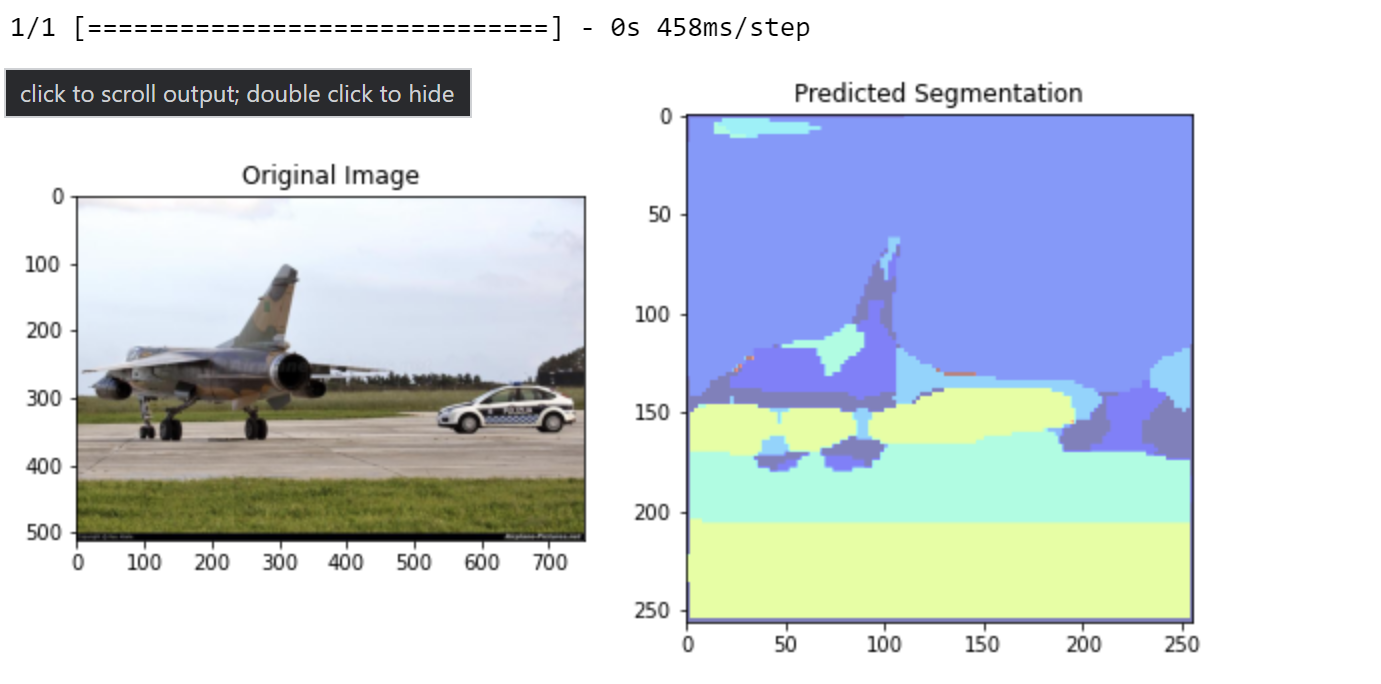

Conclusion:-
1. The best model we could train was a simple Unet Prototype for which we achieved a maximum accuracy of 40 percent. 
2. When we tried to increase the accuracy of the model we required to train the model on large dataset which was beyound of our hardware capabilities.
3. We also tried to use pretrained Unet model which was already trained on imagenet dataset, but it was a very heavy model with 33 millions weights again it was beyond hardware capabilities to finetune its weights on my dataset.
4. In future we will try tu improve this model as we gain more indepth knowledge in neural networks.